In [443]:
import numpy as np
from scipy.optimize import approx_fprime
# maximal clique problem
# target function is xT*A*x + some regularization term
# with x being an n-dimensional simplex
# (feasible set consists of probability simplexes)
# and A - a {0,1} graph adjacency matrix

def maxclique_target(A: np.ndarray, x:np.ndarray, p: int=0.5):
    '''
    Target function for the Maximal Clique Problem.
    '''
    return np.matmul(x.T,np.matmul(A,x)) + p*np.linalg.norm(x)**2

def maxclique_grad(A: np.ndarray, x: np.ndarray, penalty: str = 'l2', p: int = None, alpha: float = None, beta: float = None, eps: float = None):
    """
    Gradient calculation for the Maximal Clique Problem.

    A: a R^NxN adjacency matrix;
    x: a R^N vector;
    penalty: {'l2', 'f1', 'f2'} string specifying the type of penalty to use; defaults to l2;
    p, alpha, beta, eps: penalty parameters.
    """
    dp = 2*x
    if str.lower(penalty) == 'f1':
        raise NotImplementedError
    if str.lower(penalty) == 'f2':
        if beta <= 0 or alpha < 0 or alpha >= (2/beta**2):
            raise ValueError
        dp = alpha*np.sum(-beta*np.exp(-beta*x))

    return np.dot((A + A.T), x) + dp

def maxclique_lmo(grad):
    """
    LMO for the maximal clique problem. 
    The feasible set is the unit simplex, so return a [0,...,1,...,0] vector with 1 in place of the lowest element of the gradient.
    """
    e = np.zeros(shape=grad.shape[-1])
    idxmin = np.argmin(grad)
    e[idxmin] = 1
    return e

def frankwolfe(A: np.ndarray, x_0: float, grad=maxclique_grad, lmo=maxclique_lmo, max_iter: int = 10000, stepsize: float = None):
    '''
    Basic Frank-Wolfe algorithm.

    A: graph adjacency matrix;
    x_0: starting point;
    grad: gradient f-n;
    lmo: linear oracle;
    max_iter: max. nr of iterations;
    stepsize: defaults to 2/(k+2), step defined as (1-stepsize)*x_k + stepsize*x_k_hat.
    '''
    x_hist = [x_0]
    s_hist = []
    for k in range(max_iter):
        #g = approx_fprime(x_hist[-1], lambda x: maxclique_target(A, x))
        g = grad(A, x_hist[-1])
        s = lmo(g)
        gamma = 2/(k+2) if stepsize is None else stepsize
        x_next = (1-gamma)*x_hist[-1] + gamma*s

        x_hist.append(x_next)
        s_hist.append(s)
    return x_hist, s_hist


In [313]:
def make_test_graph(n, p):
    r = [0,1]
    A = np.tril(np.random.default_rng().choice(a=r, size=(n,n),p=[1-p, p]), k=-1)
    A = A + A.T
    return A

def draw_graph(A):
    import networkx as nx
    A_ = np.copy(A)
    G = nx.Graph(A_)
    nx.draw(G, labels={i:f'{i}' for i in range(A.shape[0])})

In [294]:
# A = np.array([
#     [0,1,1,1,0],
#     [1,0,0,0,1],
#     [1,0,0,1,1],
#     [1,0,1,0,1],
#     [0,1,1,1,0]
# ])
# n = 5

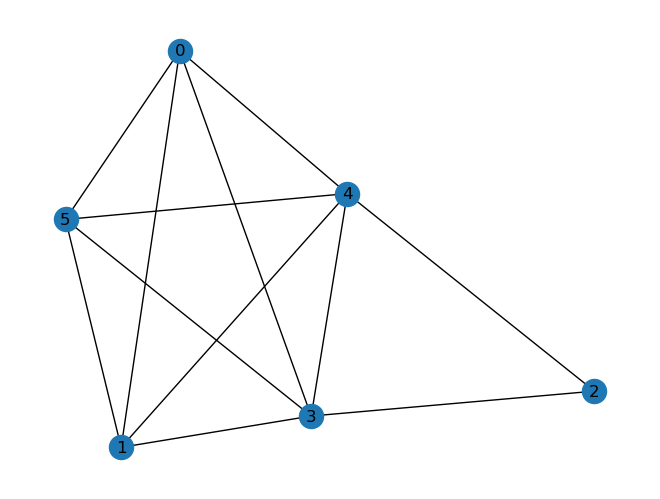

In [387]:
n = 6
A = make_test_graph(n, 0.8)
draw_graph(A)

In [444]:
x_0 = np.random.uniform(low=0.0, high=1.0, size=n)
x_0 /= np.sum(x_0)
x_hist, s_hist = frankwolfe(A=A, grad=maxclique_grad, lmo=maxclique_lmo, max_iter=10000, x_0=x_0)

In [445]:
x = x_hist[-1]
1./(1.-np.dot(np.dot(x.T,A),x))

1.0

In [446]:
def grad_wrapper(A, x):
    return -approx_fprime(x, lambda z: maxclique_target(A, z))

In [472]:
from scipy.optimize import minimize, rosen, rosen_der
bnds = [(0, None) for i_ in range(n)]
cons = ({'type': 'eq', 'fun': lambda x: x.sum()-1})
res = []
n_tries = 100
for i in range(n_tries):
    x_0 = np.random.uniform(low=0.0, high=1.0, size=n)
    x_0 /= np.sum(x_0)
    m = minimize(lambda x: -maxclique_target(A, x,p=0.5), x_0, method='SLSQP', jac = lambda x: -maxclique_grad(A, x), bounds=bnds, constraints=cons)
    res.append(m.x)

In [473]:
x_s = np.mean(res,axis=0)
x_s

array([0.09357807, 0.08239699, 0.01448233, 0.35187385, 0.36394859,
       0.09372017])

In [474]:
1./(1.-np.dot(np.dot(x_s.T,A),x_s))

3.464706435383172